# International Student Family Housing Site Selection: A Spatial Accessibility Analysis in Christchurch
Student Name: Wenjuan Wang  
Student ID: 59612505  
Course: GISC412

# 0. Data Sources  
**1) Spatial Units (SA2 Boundaries):**   

--> Source: Stats NZ (2025). Statistical Area 2 (SA2) boundaries, clipped 2025.  
--> Downloaded from: Stats NZ Data Service  
--> File used: data/statistical-area-2-2025-clipped.shp  

**2) Road Network:**  

--> Source: OpenStreetMap, accessed via the OSMnx Python package  

**3) Primary Schools:**  

--> Source: OpenStreetMap amenities (tag = amenity=school), filtered with a CSV of Christchurch primary schools downloaded from Wikipedia  
--> CSV downloaded from: https://en.wikipedia.org/wiki/List_of_schools_in_Christchurch  
--> File used: data/christchurch_primary_schools_new.csv  

**4) Bus Stops:**  

--> Source: OpenStreetMap, using tags: highway=bus_stop, amenity=bus_station, public_transport=platform/stop_position/station  

**5) Meshblock:**  

--> Source: OpenStreetMap, using tags: highway=bus_stop, amenity=bus_station, public_transport=platform/stop_position/station  
--> Downloaded from: Stats NZ Data Service   
--> File used: data/meshblock-2025-clipped.shp  

**6) University of Canterbury (UC) & Ernest Rutherford Building:**  

--> Source: OpenStreetMap, using queries:  "University of Canterbury (UC), Christchurch, New Zealand" and "Ernest Rutherford, Science Road, Ilam, Christchurch, Canterbury,New Zealand"  

# 1. Environment Setup and Global Parameters
This section imports required Python libraries and defines global parameters (e.g., mean walking speed, buffer distance, cut-off times). These parameters are consistently used across subsequent accessibility analyses.


## 1.1 Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap
from shapely.ops import substring
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon
from shapely.validation import explain_validity
from shapely.geometry import box

## 1.2 Define Global Parameters

In [2]:
# Define the crs we use in this project
UNIFORM_CRS = "EPSG:2193"
WGS84 = "EPSG:4326"
# Mean walk speed is used to compute the walking time of each OpenStreetMap(OSM) edge
# The walk speed unit is m/s
WALK_SPEED = 1.2 

# A range of 200 meters on each side of the road
LINE_BUFFER_M = 200  

# The cutoff of walking time to UC is 40 minutes (2400 s)
CUTOFF_SEC_UC = 40 * 60  

# The cutoff of walking time to primary schools is 15 minutes (900 s)
CUTOFF_SEC_PRIMARY = 15 * 60  

# The cutoff of walking time to bus stop is 15 minutes (900 s)
CUTOFF_SEC_BUS = 15 * 60 

# Roughly filter the reachable circular range based on the average walking speed(1.2 m/s) and the cutoff time limit for walking (to UC)(40*60 seconds)
RADIUS_UC = WALK_SPEED * CUTOFF_SEC_UC

# Import the administrative unit SA2
SA2 = gpd.read_file("data/statistical-area-2-2025-clipped.shp")
SA2 = SA2.to_crs(UNIFORM_CRS)

# 2. Walking Accessibility Analysis from UC (Ernest Rutherford Building, ≤40 Minutes)
In this section, the walking accessibility to the UC is analyzed using the Ernest Rutherford Building as the origin point. A pedestrian network derived from OpenStreetMap is used, and the travel times to each node from the origin point are computed using Dijkstra’s algorithm, with a cut-off of 40 minutes walking distance.

## 2.1 Define Analysis Origin (Ernest Rutherford Building)

<Axes: >

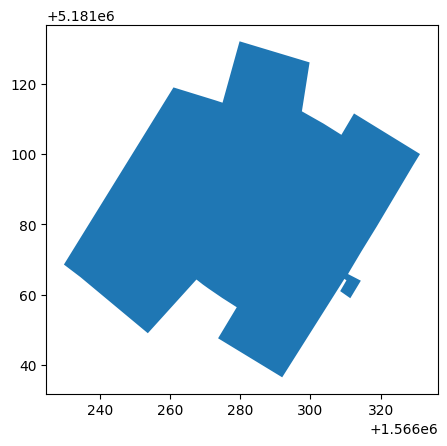

In [3]:
# Derive the entire UC boundary from the OpenStreetMap
query = "University of Canterbury, Christchurch, New Zealand"
uc_gdf = ox.geocode_to_gdf(query)

# Select UC Ernest Rutherford building as the analysis origin point, geocode to polygon
addr_dest = "Ernest Rutherford, Science Road, Ilam, Christchurch, Canterbury,New Zealand"

# Ensure the crs of ernest_point is "EPSG: 2193"
ernest_polygon = ox.geocode_to_gdf(addr_dest).to_crs(UNIFORM_CRS)

# Get centroid of the building
ernest_point = ernest_polygon.geometry.centroid
ernest_polygon.plot()


## 2.2 Select Relevant SA2 Units Intersecting UC Walking Range (Circle)

<Axes: >

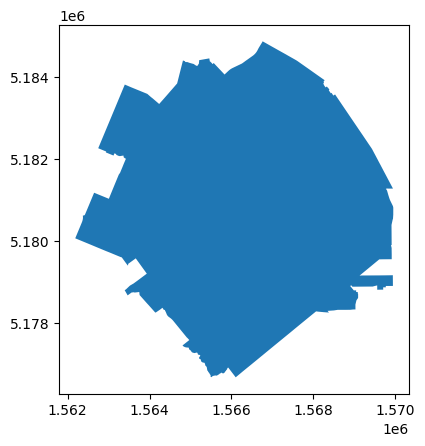

In [ ]:
# Draw a circular boundary (buffer) with a radius of 2880 m (= 40 * 60 * 1.2)
circle_UC = Point(ernest_point.x, ernest_point.y).buffer(RADIUS_UC)              
circle_UC_gdf = gpd.GeoDataFrame(geometry = [circle_UC], crs = UNIFORM_CRS) 

# Select intersecting SA2 units
SA2_selected = SA2[SA2.intersects(circle_UC)]

# Dissolve into a single outline for analysis boundary
SA2_outline = SA2_selected.dissolve()

# Extract polygon geometry
SA2_polygon = SA2_outline["geometry"].loc[0]

# Convert the crs of SA2_polygon to EPSG:4326 for OSMnx graph construction
SA2_polygon_84 = gpd.GeoSeries([SA2_polygon], crs=UNIFORM_CRS).to_crs(WGS84).geometry.iloc[0]

# Visualize the SA2_outline
SA2_outline.plot()


## 2.3 Get the Walk Graph Using OpenStreetMap Data and Compute the Travel Time Attribute 
In this step, the pedestrian network is extracted from OpenStreetMap for the study area. Each edge is assigned a travel time attribute by dividing its length by the assumed walking speed (1.2 m/s). This provides the basis for computing accessibility using Dijkstra’s shortest path algorithm in the next section.

In [5]:
# Select pedestrian network within the selected SA2_polygon_84 
G_walk = ox.graph_from_polygon(SA2_polygon_84 , network_type = "walk", simplify = True)
G_walk = ox.project_graph(G_walk, to_crs = UNIFORM_CRS)

# Assign travel_time (= edge length / WALK_SPEED) to each edge
for u, v, k, d in G_walk.edges(keys = True, data = True):
    L = d.get("length")
    # If the length attribute of the edge is None
    if L is None:
        # If the edge has geometry, then use the length of its geometry
        if d.get("geometry") is not None:
            L = d["geometry"].length
        else:
            # Otherwise, compute the Euclidean distance between the start and end nodes of the edge
            L = np.hypot(G_walk.nodes[u]["x"]-G_walk.nodes[v]["x"],
                         G_walk.nodes[u]["y"]-G_walk.nodes[v]["y"])
        d["length"] = L
    # Convert the length of the edge to travel time = distance / walking speed and store in attribute 'travel_time (second)'
    d["travel_time"] = float(L) / float(WALK_SPEED)

## 2.4 Grid-Based Travel-Time Classification from UC
Starting from the Ernest Rutherford Building at UC, the shortest walking time (in seconds) to each network node is computed using Dijkstra’s algorithm on the pedestrian network. Within the study area, a 25 m grid is generated. Each grid cell centroid is snapped to the nearest network node, and the walking time from that node to the origin (ernest node) is assigned to the grid. The cells are then classified into time bands (0–5, 5–10, 10-20, 30–40, >40, unreachable). Next, the grid cells are dissolved by band to create polygons for each travel-time zone.

<Axes: >

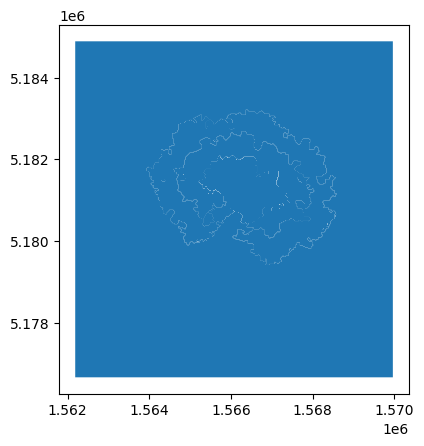

In [ ]:
# Snap the Ernest Rutherford building centroid point to the nearest network node
ernest_node = ox.distance.nearest_nodes(G_walk, ernest_point.x.iloc[0], ernest_point.y.iloc[0])

# Compute the shortest walking time from the ernest_node to every reachable node based on the 'travel_time' edge weight
time_from_ernest = nx.single_source_dijkstra_path_length(
    G_walk, ernest_node, weight = "travel_time"
)

# Classify the grids by walking time, multiplying 60 to convert to unit 'second'
def band_uc(time):
    if not np.isfinite(time): return "unreachable"
    if time <= 5 * 60:   return "0-5"
    if time <= 10 * 60:  return "5-10"
    if time <= 20 * 60:  return "10-20"
    if time <= 30 * 60:  return "20-30"
    if time <= 40 * 60:  return "30-40"
    return ">40"

# Compute SA2 boundary bounds
minx, miny, maxx, maxy = SA2_polygon.bounds

# Generate a 25 m grid within the bounding box
grid = []
step = 25

cells = [Polygon([(x,y),(x + step, y),(x + step,y + step),(x, y + step)])
         for x in np.arange(minx, maxx, step)
         for y in np.arange(miny, maxy, step)]
grid = gpd.GeoDataFrame(geometry = cells, crs = UNIFORM_CRS)
grid["centroid"] = grid.geometry.centroid

# For each grid centroid, assign the walking time from its nearest node to the ernest_node (origion node)
grid["nearest_node"] = ox.distance.nearest_nodes(G_walk, grid["centroid"].x.values, grid["centroid"].y.values)
grid["time_sec"] = grid["nearest_node"].map(time_from_ernest).fillna(np.inf)
grid = grid.drop(columns = ["centroid"])

# Classify time_sec attribute into bands
grid["band"] = grid["time_sec"].apply(band_uc)

# Dissolve grid by band
classified_grid = grid.dissolve(by = "band")  
classified_grid.plot()

# 3. Walking Accessibility Analysis from Primary School (≤15 Minutes)
This section evaluates the walking accessibility of primary schools in Christchurch, an important factor for international student families who often prioritize school proximity when selecting housing. Primary school locations were first extracted from **OpenStreetMap (OSM)** and cross-referenced with an CSV list to ensure data completeness and consistency. Walking accessibility was then computed using the OSMnx-based pedestrian network, with a cutoff of 15 minutes (900 seconds) representing a reasonable walking distance for school-aged children. Results were classified into travel-time bands (0–5, 5–10, 10–15 minutes, >15 minutes).

## 3.1 Extract and Prepare Primary School Locations from OSM and CSV

In [7]:
# Filter the primary school points within "Christchurch, New Zealand" from the OpenStreetMap 
place_name = "Christchurch, New Zealand"

# Transform the CRS from WGS84 into EPSG:2193
schools = ox.features_from_place(place_name, tags={"amenity": "school"}).to_crs(UNIFORM_CRS)

# The primary schools in OSM contain points and polygons, which we need to convert to points
schools_points = schools.copy()

# Define a function to convert polygons into points
def polygon_2_point(geo):
    if geo is None or geo.is_empty:
        return None
    geoType = geo.geom_type
    if geoType == "Point":
        return geo
    if geoType in ("Polygon", "MultiPolygon"):
        return geo.representative_point()

# Replace the polygons by coverted points
schools_points["geometry"] = schools.geometry.apply(polygon_2_point)

# Import the primary school name list(csv) and merge it with the school_points
primary_school_names = pd.read_csv("data/christchurch_primary_schools_new.csv")
primary_school_names["PrimarySchool"] = "Yes"
primarySchool_points = schools_points.merge(primary_school_names,how="inner", left_on="name", right_on="new_name")
primarySchool_points = primarySchool_points[["geometry","addr:postcode","addr:street","new_name","Years","Opened","PrimarySchool"]]

## 3.2 Grid-Based Travel-Time Classification from Primary Schools

C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\2239981464.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  edge_buffer = edges_walk.buffer(LINE_BUFFER_M).unary_union
C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\2239981464.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  edge_buffer = edges_walk.buffer(LINE_BUFFER_M).unary_union


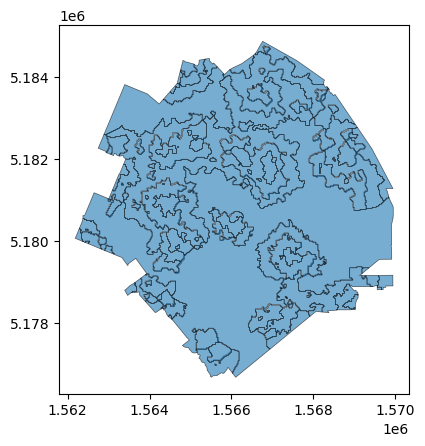

In [ ]:
# Snap each primary school point to its nearest walk-network node
school_nodes = ox.distance.nearest_nodes(G_walk, primarySchool_points.geometry.x.values, primarySchool_points.geometry.y.values)
# Reduce deduplicates
school_nodes = list(sorted(set(school_nodes)))  

# Multi-source shortest time: walking time (seconds) from any node to the nearest primary school
times_to_school = nx.multi_source_dijkstra_path_length(
    G_walk, school_nodes, cutoff = CUTOFF_SEC_PRIMARY, weight="travel_time"
)

# Network-corridor filter to avoid snapping across rivers/obstacles
edges_walk = ox.graph_to_gdfs(G_walk, nodes=False)
edge_buffer = edges_walk.buffer(LINE_BUFFER_M).unary_union    

# Define bandings for primary schools (0–5 / 5–10 / 10–15 / >15 minutes)
def band_school(time):
    if time <= 5 * 60:   return "0–5"
    if time <= 10 * 60:  return "5–10"
    if time <= 15 * 60:  return "10–15"
    return ">15"

# Generate a 25 m grid
minx, miny, maxx, maxy = SA2_polygon.bounds
step = 25
cells = [Polygon([(x,y),(x + step, y),(x + step,y + step),(x, y + step)])
         for x in np.arange(minx, maxx, step)
         for y in np.arange(miny, maxy, step)]
grid = gpd.GeoDataFrame(geometry = cells, crs = UNIFORM_CRS)

# Get the nearest network node for each of the grid centroid
# Then compute the time from each centroid node to the nearest primary school
cent = grid.geometry.centroid

# Network-corridor filter to avoid snapping across barriers
edges_walk = ox.graph_to_gdfs(G_walk, nodes=False)
edge_buffer = edges_walk.buffer(LINE_BUFFER_M).unary_union
grid["near_net"] = cent.within(edge_buffer)

# Nearest node (compute only for centroids flagged as near_net=True)
grid["nearest_node"] = np.nan
mask = grid["near_net"]
grid.loc[mask, "nearest_node"] = ox.distance.nearest_nodes(
    G_walk, cent.x[mask].values, cent.y[mask].values
)

# Map walking time
grid["time_sec"] = np.inf
grid.loc[mask, "time_sec"] = grid.loc[mask, "nearest_node"].map(times_to_school).fillna(np.inf)

# Banding and dissolve
grid["band"] = grid["time_sec"].apply(band_school)
school_band_grid = grid.dissolve(by="band", as_index=True)  

# Clip to the study area boundary
school_band_grid = gpd.overlay(
    school_band_grid.reset_index(),
    gpd.GeoDataFrame(geometry=[SA2_polygon], crs = UNIFORM_CRS),
    how="intersection"
).set_index("band")

# Visualize 
ax = school_band_grid.plot(edgecolor="k", linewidth=0.5, alpha=0.6)


# 4. Walking Accessibility Analysis from Bus Stop (≤15 Minutes)
In this section, we use OpenStreetMap (OSM) bus stop data to analyze walking accessibility within the Christchurch urban area. We first extract and process all bus stop locations, then apply network analysis to calculate walking times from each grid cell to the nearest bus stop. The results are classified into three categories: 0–5 minutes, 5–10 minutes, and 10–15 minutes.


## 4.1 Extract and Prepare Bus Stop Locations from OSM

In [9]:
# Extract all bus-related stops in Christchurch
tags = {
    "highway": "bus_stop",                 
    "amenity": "bus_station",              
    "public_transport": ["platform", "stop_position", "station"]  
}
bus_stations_raw = ox.features_from_place(place_name, tags = tags).to_crs(UNIFORM_CRS)

# Keep only public transport elements related to buses 
is_bus = (
    (bus_stations_raw.get("highway") == "bus_stop") |
    (bus_stations_raw.get("amenity") == "bus_station") |
    (bus_stations_raw.get("bus") == "yes")  
)
bus_stations = bus_stations_raw[is_bus].copy()
bus_stations = bus_stations[["geometry","bus","highway","public_transport"]]

# Convert all the bus stop geometries to points 
def to_points(df):
    geoms = []
    for g in df.geometry:
        if g.geom_type == "Point":
            geoms.append(g)
        else:
            geoms.append(g.representative_point())  
    out = gpd.GeoDataFrame(df.drop(columns="geometry"), geometry = geoms, crs = UNIFORM_CRS)
    return out
bus_stations_points = to_points(bus_stations)


## 4.2 Grid-Based Travel-Time Classification from Bus Stops

In [10]:
# Multi-source shortest time to the nearest bus stop
# Snap bus stops to the nearest walk-network nodes and reduce deduplicate
bus_nodes = ox.distance.nearest_nodes(G_walk, bus_stations_points.geometry.x.values, bus_stations_points.geometry.y.values)
# Remove the duplicates
bus_nodes = list(sorted(set(bus_nodes)))  

# Compute walking times (seconds) from any node to the nearest bus stop
times_to_bus = nx.multi_source_dijkstra_path_length(
    G_walk, bus_nodes, cutoff = CUTOFF_SEC_BUS, weight = "travel_time"
)

# Generate a 25-m grid 
minx, miny, maxx, maxy = SA2_polygon.bounds   
step = 25
cells = [Polygon([(x,y),(x + step, y),(x + step,y + step),(x, y + step)])
         for x in np.arange(minx, maxx, step)
         for y in np.arange(miny, maxy, step)]
grid = gpd.GeoDataFrame(geometry = cells, crs = UNIFORM_CRS)

# Find the nearest node for each grid centroid, then compute the walking time from the nearest node to nearest bus stop
cent = grid.geometry.centroid   
grid["nearest_node"] = ox.distance.nearest_nodes(G_walk, cent.x.values, cent.y.values)
grid["time_sec"] = grid["nearest_node"].map(times_to_bus).fillna(np.inf)

# Define the bandings for bus stop
def band_bus(t):
    if t <= 5 * 60:   return "0-5"
    if t <= 10 * 60:  return "5-10"
    if t <= 15 * 60:  return "10-15"
    return ">15"

grid["band"] = grid["time_sec"].apply(band_bus)
# Merge cells into travel-time rings
bus_band_grid = grid.dissolve(by="band")  

# Clip to the study-area boundary
bus_band_grid = gpd.overlay(
    bus_band_grid.reset_index(),
    gpd.GeoDataFrame(geometry=[SA2_polygon], crs = UNIFORM_CRS),
    how="intersection"
).set_index("band")


# 5. Integrated Accessibility Scoring and Suitability Mapping
In this section, we integrate the results of the individual accessibility analyses (UC, primary schools, and bus stops) into a composite housing suitability index. Isochrone layers from each factor are first normalized to a common scale, and then weighted scores are assigned to reflect their relative importance (e.g., higher weight for school accessibility). The combined suitability surface is subsequently classified into five categories ranging from Very Low to Very High. This integrated scoring and mapping process provides a comprehensive spatial evaluation of housing options for international student families, highlighting areas with the most favorable accessibility conditions.

## 5.1 Normalize Isochrone Layers and Assign Scores

In [11]:
# Create Isochrone grids (polygon bands)
# 1） UC accessibility zones
grid_UC = classified_grid.copy().reset_index()

# Normalize band labels (replace en-dash “–” with a regular hyphen “-” for consistency)
band_norm = grid_UC["band"].astype(str).str.replace("–", "-", regex = False)

# Map each time band to a score (higher score = more accessible)
mapping = {
    "0-5":   5,
    "5-10":  4,
    "10-20": 3,
    "20-30": 2,
    "30-40": 1,
}
grid_UC["UC_score"] = band_norm.map(mapping).fillna(0).astype(int)
grid_UC["UC_score"].value_counts(dropna = False).sort_index()

# Keep only cells with positive scores and normalize to 0–1 scale
grid_UC = grid_UC[grid_UC["UC_score"] > 0].copy()
grid_UC["UC_norm"]  = (grid_UC["UC_score"]  - 1) / (5.0 - 1.0)

# 2) Primary school accessibility zones
grid_school = school_band_grid.copy().reset_index()

# Normalize band labels (replace en-dash “–” with a regular hyphen “-” for consistency)
band_norm = grid_school["band"].astype(str).str.replace("–", "-", regex = False)

# Map each time band to a score (higher score = more accessible)
mapping = {
    "0-5":   3,
    "5-10":  2,
    "10-15": 1,    
}
grid_school["school_score"] = band_norm.map(mapping).fillna(0).astype(int)
grid_school["school_score"].value_counts(dropna=False).sort_index()

# Keep only valid scores and normalize to 0–1
grid_school = grid_school[grid_school["school_score"] >= 0].copy()
grid_school["school_norm"]  = (grid_school["school_score"]  - 1) / (3.0 - 1.0)
grid_school = grid_school[grid_school["school_norm"] >= 0.0]

# 3) Bus stop accessibility zones
bus_grid = bus_band_grid.copy().reset_index()

# Normalize band labels (replace en-dash “–” with a regular hyphen “-” for consistency)
band_norm = bus_grid["band"].astype(str).str.replace("–", "-", regex=False)

# Map each time band to a score (higher score = more accessible)
mapping = {
    "0-5":   3,
    "5-10":  2,
    "10-15": 1,    
}
bus_grid["bus_score"] = band_norm.map(mapping).fillna(0).astype(int)
bus_grid["bus_score"].value_counts(dropna=False).sort_index()

# Keep only valid scores and normalize to 0–1
bus_grid = bus_grid[bus_grid["bus_score"] >= 0].copy()
bus_grid["bus_norm"]  = (bus_grid["bus_score"]  - 1) / (3.0 - 1.0)
bus_grid = bus_grid[bus_grid["bus_norm"] >= 0.0]


## 5.2 Overlay Isochrone Layers to Identify Common Accessible Areas

In [ ]:
# UC accessibility zones vs. primary school accessibility zones
uc_school = gpd.overlay(grid_UC, grid_school, how="intersection")

# (UC + primary school) vs. bus accessibility zones
grid_intersection = gpd.overlay(uc_school, bus_grid, how="intersection")

c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 80 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 148 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


## 5.3 Weighted Scoring and Quantile Classification of Accessibility

In [ ]:
# 1) Use the "Total" score in grid_intersection to calculate quantile thresholds
# weights: primary school (w_s = 0.50)> UC (w_u = 0.35)> bus stop (w_b = 0.15)
w_s, w_u, w_b = 0.50, 0.35, 0.15   
grid_intersection["Total"] = (
    w_s * grid_intersection["school_norm"] +
    w_u * grid_intersection["UC_norm"] +
    w_b * grid_intersection["bus_norm"]
)
s_g = pd.to_numeric(grid_intersection["Total"], errors="coerce").clip(0,1).fillna(0)

# Calculate quantiles (q1..q4 at 20%, 40%, 60%, 80%)
q = s_g.quantile([0.2, 0.4, 0.6, 0.8])   
q1, q2, q3, q4 = q[0.2], q[0.4], q[0.6], q[0.8]

# 2) Handle the issue of repeated quantile values causing non-increasing bins
bins = np.array([-np.inf, q1, q2, q3, q4, np.inf], dtype=float)
bins = np.maximum.accumulate(bins) 
bins = np.unique(bins)              

# If too many identical values reduce the number of bins, fall back to equal-width binning
if len(bins) < 6:
    bins = np.linspace(0, 1, 6)
    bins[0]  = -np.inf
    bins[-1] =  np.inf

labels5 = ["Very Low","Low","Mid","High","Very High"]

grid_intersection["Total_quantile"] = pd.cut(
    s_g, bins=bins, labels=labels5[:len(bins)-1], include_lowest=True
)



## 5.4 Clean the Classified Grid Polygons

In [ ]:
# Explode MultiPolygon into individual Polygons
grid_exploded = grid_intersection.explode(index_parts=False).reset_index(drop=True)

# Project to a metric CRS (NZTM2000, EPSG:2193) for accurate area calculation
grid_exploded = grid_exploded.to_crs(UNIFORM_CRS)

# Add area field
grid_exploded["area"] = grid_exploded.geometry.area

grid_filtered = grid_exploded.copy()

# Dissolve back by classification
grid_clean = grid_filtered.dissolve(by="Total_quantile").reset_index()

# Light smoothing to reduce pixelated edges
grid_smooth = grid_clean.copy()

                 

# 6. Map Visualization
In this section, four maps are presented to visualize the results of the accessibility and suitability analysis. These maps integrate multiple spatial layers such as UC accessibility, primary schools, bus stops, and administrative boundaries. Together, they provide a clear spatial representation of housing suitability patterns for international student families in Christchurch.


## 6.1 Map Visualization of UC Accessibility


c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 137 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\3279500663.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


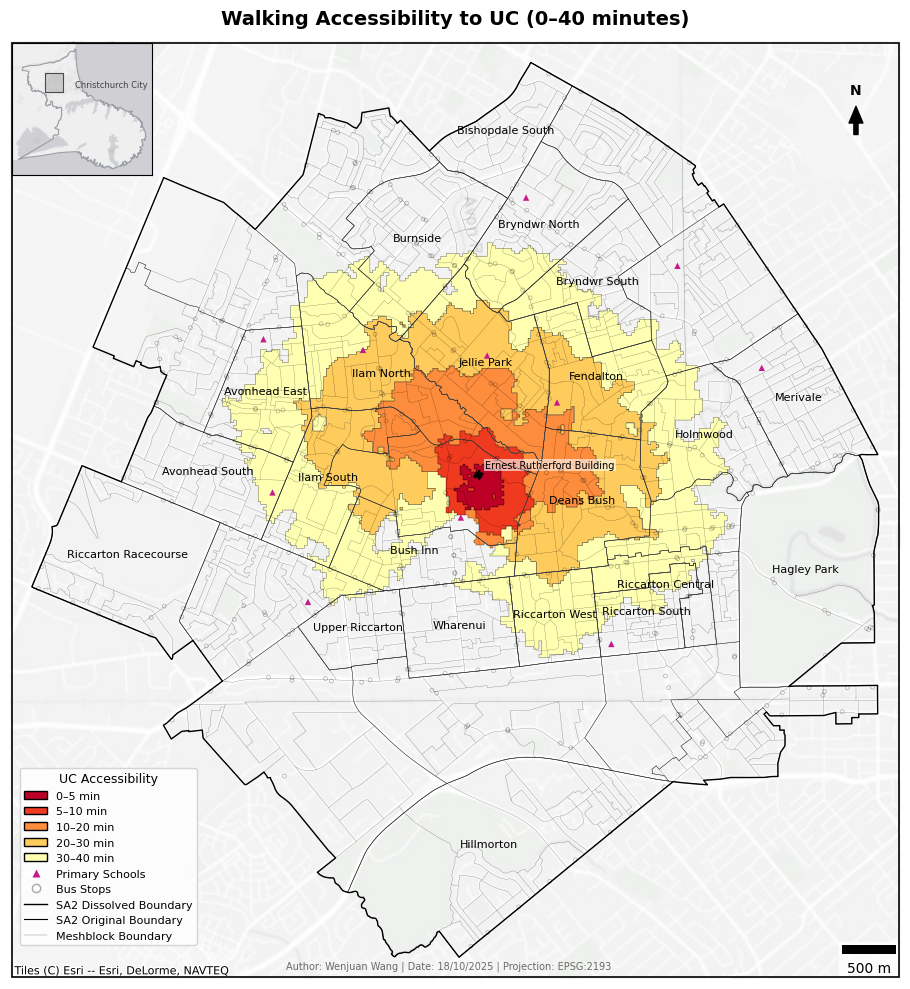

In [15]:
# 1. UC Accessibility Heatmap and Basemap
fig, ax = plt.subplots(figsize=(10, 10))
heat_colors = ["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
heat_cmap = LinearSegmentedColormap.from_list("custom_heat", heat_colors)
grid_UC.plot(
    ax = ax,
    column = "UC_norm",      
    cmap = heat_cmap,        
    edgecolor = "black",     
    linewidth = 0.2,
    legend = False,           
)
# 2. Legend and Symbols
heat_colors = ["#bd0026","#f03b20", "#fd8d3c", "#fecc5c", "#ffffb2"]
uc_labels = ["0–5 min","5–10 min","10–20 min","20–30 min","30–40 min"]
legend_elements = (
    [Patch(facecolor = col, edgecolor = 'black', label = lab) 
     for col, lab in zip(heat_colors, uc_labels)] +
    [Line2D([0], [0], marker = '^', color = 'w', markerfacecolor = '#c51b8a',
            markeredgecolor = 'none', markersize=6, label='Primary Schools')] +
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
            markeredgecolor="darkgray", markersize=6, label='Bus Stops')] +
    [
        Line2D([0], [0], color='black', linewidth=1, label='SA2 Dissolved Boundary'),
        Line2D([0], [0], color='black', linewidth=0.8, label='SA2 Original Boundary'),
        Line2D([0], [0], color='gray',  linewidth=0.3, label='Meshblock Boundary')
    ]
)
ax.legend(handles = legend_elements, loc='lower left', frameon = True, bbox_to_anchor=(0.005, 0.03), 
          fontsize = 8, title="UC Accessibility", title_fontsize = 9)

# 3. North Arrow and Scalebar
def add_north(ax, loc=(0.95, 0.9), size=0.03):
    x, y = loc
    ax.annotate("", xy=(x, y+size), xytext=(x, y), xycoords=ax.transAxes,
                arrowprops=dict(facecolor="black", width=3, headwidth=10))
    ax.text(x, y+size+0.01, "N", transform=ax.transAxes,
            ha="center", va="bottom", fontsize=10, weight="bold")
add_north(ax)
scalebar = ScaleBar(
    dx=1,                  
    units="m",             
    dimension="si-length", 
    fixed_value=500,       
    fixed_units="m",       
    location="lower right", 
    box_alpha=0.7          
)
ax.add_artist(scalebar)

# 4. Annotating Key Features
ernest_polygon.plot(ax=ax, color="black", linewidth=1.0)
ernest_centroid = ernest_polygon.geometry.centroid.iloc[0]
ax.annotate(
    "Ernest Rutherford Building",            
    xy=(ernest_centroid.x, ernest_centroid.y),  
    xytext=(5, 5),                           
    textcoords="offset points",
    fontsize=7,
    color="black",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
)
# Suburb labels
suburbs = SA2_selected.copy()
target_suburbs = suburbs[suburbs["SA22025__1"].isin(["Burnside", "Fendalton", "Riccarton Central", "Bryndwr North", "Ilam North",
                                                     "Ilam South", "Avonhead East","Upper Riccarton","Avonhead South",
                                                     "Holmwood", "Bishopdale South","Bryndwr South", "Bush Inn","Merivale",
                                                     "Hagley Park","Hillmorton","Wharenui","Riccarton Racecourse","Riccarton West",
                                                     "Riccarton South","Jellie Park","Deans Bush"
                                                     ])]

target_suburbs.boundary.plot(ax=ax, color="grey", linewidth=0.5)
for idx, row in target_suburbs.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["SA22025__1"],
            fontsize=8, color="black", ha="center")
 
# 5. Administrative Boundaries and Meshblocks
SA2_outline = SA2_selected.dissolve()
SA2_selected.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=0.3, 
    linestyle="---", 
    zorder=3,
    alpha=0.5
)
SA2_outline.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=1, 
    linestyle="-", 
    zorder=4
)
meshblock = gpd.read_file("data/meshblock-2025-clipped.shp")
meshblock = meshblock.to_crs(SA2_outline.crs)
meshblock_in = gpd.overlay(meshblock, SA2_outline, how="intersection")
meshblock_in.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2, alpha=0.3,zorder = 2)

# 6. Schools and Bus Stops
bus_stations_in_sa2 = bus_stations_points[
    bus_stations_points.intersects(SA2_outline.geometry.iloc[0])
]
bus_stations_in_sa2.plot(ax=ax, markersize=8, color="none", edgecolor="black", linewidth=0.5, marker="o",zorder = 5, alpha=0.3)
schools_in_sa2  = primarySchool_points[primarySchool_points.intersects(SA2_outline.geometry.iloc[0])]

schools_in_sa2.plot(ax=ax, markersize=21, color="#c51b8a", edgecolor="none", linewidth=0.5, marker="^",zorder = 5)


# 7. Inset Map (Location Map)
boundary = ox.geocode_to_gdf("Christchurch City, Canterbury, New Zealand")
boundary = boundary.to_crs(UNIFORM_CRS)

axins = fig.add_axes([0.057, 0.815, 0.14, 0.14])
axins.set_facecolor("#F4F5F7")
axins.set_frame_on(True)

g_main = SA2_outline.to_crs(UNIFORM_CRS)
minx, miny, maxx, maxy = g_main.total_bounds
pad_m = 400
study_box = box(minx - pad_m, miny - pad_m, maxx + pad_m, maxy + pad_m)
study_gdf = gpd.GeoDataFrame(geometry=[study_box], crs = UNIFORM_CRS)
study_gdf.plot(ax=axins, color="#4A4A4A", alpha=0.2, edgecolor="none", zorder=3)
study_gdf.boundary.plot(ax=axins, color="#4A4A4A", linewidth=0.8, zorder=4)
boundary.boundary.plot(ax=axins, color="#9AA0A6", linewidth=0.8, zorder=2)
ctx.add_basemap(
    axins,
    source="https://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}",  
    crs=UNIFORM_CRS,
    zoom=11
)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axins.text(0.45, 0.65, "Christchurch City", transform=axins.transAxes,
           fontsize=6, color="#444", ha="left", va="bottom")

# 8. Final Formatting
pad_axes = 0.002
frame = Rectangle((pad_axes, pad_axes), 1-2*pad_axes, 1-2*pad_axes,
                  transform=ax.transAxes, fill=False,
                  edgecolor="black", linewidth=1.2, zorder=1000)
ax.add_patch(frame)
ws, wu, wb = (0.50, 0.35, 0.15)
ax.set_title(
    "Walking Accessibility to UC (0–40 minutes)",
    fontsize=14, weight="bold", loc="center", pad=12
)
ax.text(0.31, 0.02,
    "Author: Wenjuan Wang | Date: 18/10/2025 | Projection: EPSG:2193",
    transform=ax.transAxes, va="top", ha="left", fontsize=7, color="dimgray")
minx, miny, maxx, maxy = SA2_selected.total_bounds
pad = 200  
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad) 
ctx.add_basemap(
    ax,
    source = ctx.providers.Esri.WorldGrayCanvas,
    crs = grid_UC.crs.to_string(),
    alpha = 0.6
)
ax.set_aspect("equal"); ax.set_axis_off()
ax.grid(True, which='both', color='lightgray', linewidth=0.5)
plt.tight_layout()
plt.savefig("data/output/map_UC_accessibility.png", dpi=400, bbox_inches="tight")
plt.show()


## 6.2 Map Visualization of Primary School Accessibility


c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 137 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\4162576555.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


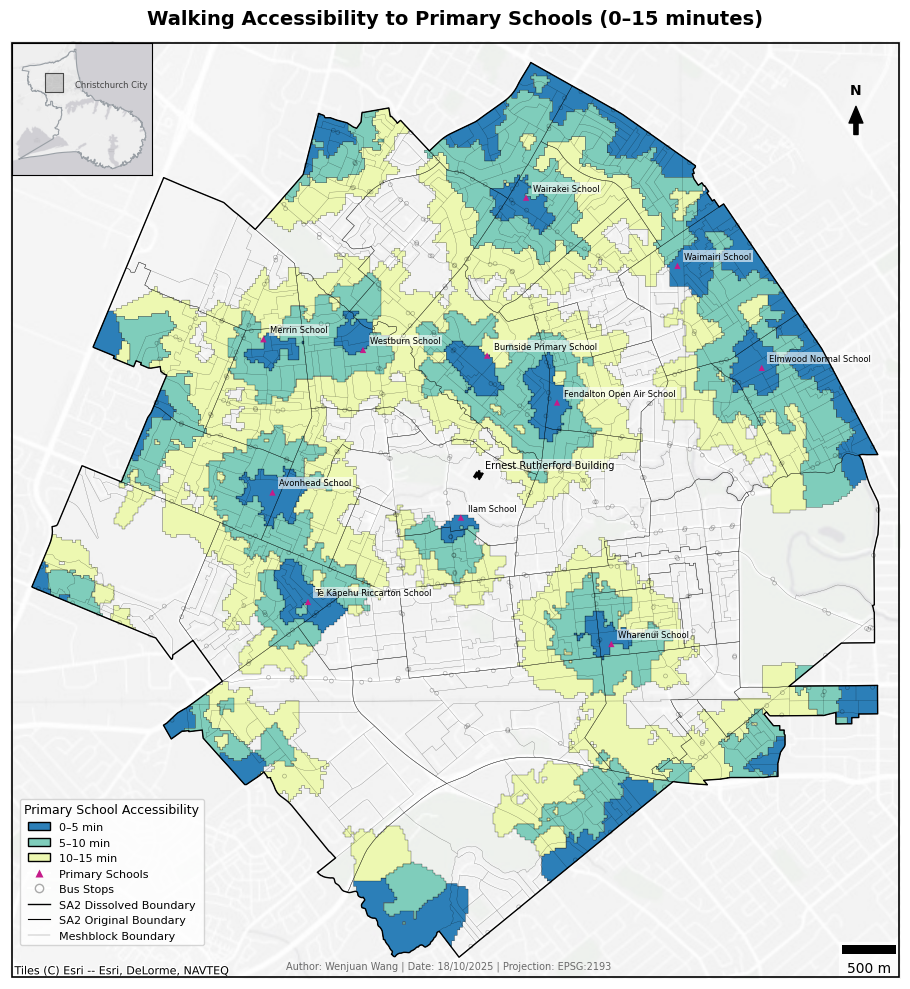

In [16]:
# 1. Primary School Accessibility Heatmap 
fig, ax = plt.subplots(figsize=(10, 10))
blue_colors = ["#edf8b1", "#7fcdbb", "#2c7fb8"]
blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
grid_school.plot(
    ax=ax,
    column="school_norm",      
    cmap=blue_cmap,        
    edgecolor="black",     
    linewidth=0.2,
    legend=False          
)

# 2. Legend & Symbols
blue_colors = ["#2c7fb8","#7fcdbb", "#edf8b1"]
school_labels = [
    "0–5 min", 
    "5–10 min", 
    "10–15 min"
]
legend_elements = (
    [Patch(facecolor=col, edgecolor='black', label=lab) 
     for col, lab in zip(blue_colors, school_labels)] +
    [Line2D([0], [0], marker='^', color='w', markerfacecolor='#c51b8a',
            markeredgecolor='none', markersize=6, label='Primary Schools')] +
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
            markeredgecolor="darkgray", markersize=6, label='Bus Stops')] +
    [
        Line2D([0], [0], color='black', linewidth=1, label='SA2 Dissolved Boundary'),
        Line2D([0], [0], color='black', linewidth=0.8, label='SA2 Original Boundary'),
        Line2D([0], [0], color='gray',  linewidth=0.3, label='Meshblock Boundary')
    ]
)
ax.legend(handles=legend_elements, loc='lower left', frameon=True, bbox_to_anchor=(0.005, 0.03), 
          fontsize=8, title="Primary School Accessibility", title_fontsize=9)

# 3. North Arrow & Scalebar
def add_north(ax, loc=(0.95, 0.9), size=0.03):
    x, y = loc
    ax.annotate("", xy=(x, y+size), xytext=(x, y), xycoords=ax.transAxes,
                arrowprops=dict(facecolor="black", width=3, headwidth=10))
    ax.text(x, y+size+0.01, "N", transform=ax.transAxes,
            ha="center", va="bottom", fontsize=10, weight="bold")
add_north(ax)
scalebar = ScaleBar(
    dx=1,                  
    units="m",             
    dimension="si-length", 
    fixed_value=500,       
    fixed_units="m",       
    location="lower right", 
    box_alpha=0.7          
)
ax.add_artist(scalebar)

# 4. Annotating Key Features
ernest_polygon.plot(ax=ax, color="black", linewidth=1.0)
ernest_centroid = ernest_polygon.geometry.centroid.iloc[0]
ax.annotate(
    "Ernest Rutherford Building",            
    xy=(ernest_centroid.x, ernest_centroid.y), 
    xytext=(5, 5),                           
    textcoords="offset points",
    fontsize=7,
    color="black",
    # weight="bold",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
)

# 5. Administrative Boundaries & Meshblocks
SA2_outline = SA2_selected.dissolve()
SA2_selected.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=0.3, 
    linestyle="---", 
    zorder=3,
    alpha=0.5
)
SA2_outline.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=1, 
    linestyle="-", 
    zorder=4
)

meshblock = gpd.read_file("data/meshblock-2025-clipped.shp")
meshblock = meshblock.to_crs(UNIFORM_CRS)
meshblock_in = gpd.overlay(meshblock, SA2_outline, how="intersection")
meshblock_in.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2, alpha=0.3,zorder = 2)

# 6. Schools & Bus Stops
bus_stations_in_sa2 = bus_stations_points[
    bus_stations_points.intersects(SA2_outline.geometry.iloc[0])
]
bus_stations_in_sa2.plot(ax=ax, markersize=8, color="none", edgecolor="black", linewidth=0.5, marker="o",zorder = 5, alpha=0.3)
schools_in_sa2  = primarySchool_points[primarySchool_points.intersects(SA2_outline.geometry.iloc[0])]

for idx, row in schools_in_sa2.iterrows():
        ax.annotate(
        row["new_name"], 
        xy=(row.geometry.x, row.geometry.y), 
        xytext=(5, 5),  
        textcoords='offset points',
        fontsize=6, 
        color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1) 
    )
schools_in_sa2.plot(ax=ax, markersize=21, color="#c51b8a", edgecolor="none", linewidth=0.5, marker="^",zorder = 5)

# 7. Inset Map (Locator)
boundary = ox.geocode_to_gdf("Christchurch City, Canterbury, New Zealand")
boundary = boundary.to_crs(UNIFORM_CRS)
axins = fig.add_axes([0.057, 0.815, 0.14, 0.14])
axins.set_facecolor("#F4F5F7")
axins.set_frame_on(True)

g_main = SA2_outline.to_crs(UNIFORM_CRS)
minx, miny, maxx, maxy = g_main.total_bounds
pad_m = 400
study_box = box(minx - pad_m, miny - pad_m, maxx + pad_m, maxy + pad_m)
study_gdf = gpd.GeoDataFrame(geometry=[study_box], crs=UNIFORM_CRS)
study_gdf.plot(ax=axins, color="#4A4A4A", alpha=0.2, edgecolor="none", zorder=3)
study_gdf.boundary.plot(ax=axins, color="#4A4A4A", linewidth=0.8, zorder=4)
boundary.boundary.plot(ax=axins, color="#9AA0A6", linewidth=0.8, zorder=2)
ctx.add_basemap(
    axins,
    source="https://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}",  
    crs=UNIFORM_CRS,
    zoom=11
)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axins.text(0.45, 0.65, "Christchurch City", transform=axins.transAxes,
           fontsize=6, color="#444", ha="left", va="bottom")

# 8. Final Formatting & Export
pad_axes = 0.002
frame = Rectangle((pad_axes, pad_axes), 1-2*pad_axes, 1-2*pad_axes,
                  transform=ax.transAxes, fill=False,
                  edgecolor="black", linewidth=1.2, zorder=1000)
ax.add_patch(frame)
ax.set_title(
    "Walking Accessibility to Primary Schools (0–15 minutes)",
    fontsize=14, weight="bold", loc="center", pad=12
)
ax.text(0.31, 0.02,
    "Author: Wenjuan Wang | Date: 18/10/2025 | Projection: EPSG:2193",
    transform=ax.transAxes, va="top", ha="left", fontsize=7, color="dimgray")

minx, miny, maxx, maxy = SA2_selected.total_bounds
pad = 200  
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)
ctx.add_basemap(
    ax,
    source = ctx.providers.Esri.WorldGrayCanvas,
    crs = grid_UC.crs.to_string(),
    alpha = 0.6
)
ax.set_aspect("equal"); ax.set_axis_off()
ax.grid(True, which='both', color='lightgray', linewidth=0.5)
plt.tight_layout()
plt.savefig("data/output/map_PrimarySchool_accessibility.png", dpi=400, bbox_inches="tight")
plt.show()

## 6.3 Map Visualization of Bus stop Accessibility


c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 137 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\4167088730.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


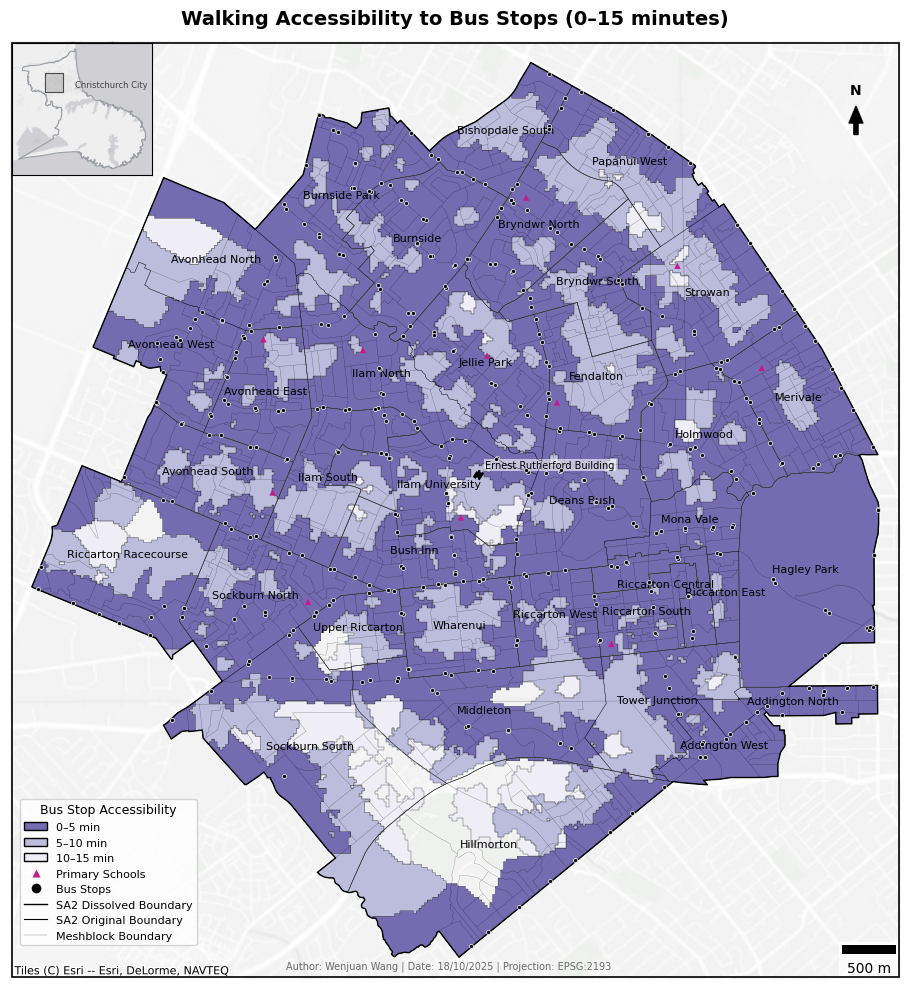

In [17]:
# 1. Bus Stop Accessibility Heatmap 
fig, ax = plt.subplots(figsize=(10, 10))
purple_colors = ["#efedf5", "#bcbddc", "#756bb1"]
purple_cmap = LinearSegmentedColormap.from_list("custom_purple", purple_colors)
bus_grid.plot(
    ax=ax,
    column="bus_norm",      
    cmap=purple_cmap,       
    edgecolor="black",     
    linewidth=0.2,
    legend=False          
)
# 2. Legend & Symbols
purple_colors = ["#756bb1","#bcbddc", "#efedf5"]
bus_labels = [
    "0–5 min", 
    "5–10 min", 
    "10–15 min"
]
legend_elements = (
    [Patch(facecolor=col, edgecolor='black', label=lab) 
     for col, lab in zip(purple_colors, bus_labels)] +
    [Line2D([0], [0], marker='^', color='w', markerfacecolor='#c51b8a',
            markeredgecolor='none', markersize=6, label='Primary Schools')] +
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
            markeredgecolor="white", markersize=8, label='Bus Stops')] +
    [
        Line2D([0], [0], color='black', linewidth=1, label='SA2 Dissolved Boundary'),
        Line2D([0], [0], color='black', linewidth=0.8, label='SA2 Original Boundary'),
        Line2D([0], [0], color='gray',  linewidth=0.3, label='Meshblock Boundary')
    ]
)
ax.legend(handles=legend_elements, loc='lower left', frameon=True, bbox_to_anchor=(0.005, 0.03), 
          fontsize=8, title="Bus Stop Accessibility", title_fontsize=9)

# 3. North Arrow & Scalebar
def add_north(ax, loc=(0.95, 0.9), size=0.03):
    x, y = loc
    ax.annotate("", xy=(x, y+size), xytext=(x, y), xycoords=ax.transAxes,
                arrowprops=dict(facecolor="black", width=3, headwidth=10))
    ax.text(x, y+size+0.01, "N", transform=ax.transAxes,
            ha="center", va="bottom", fontsize=10, weight="bold")
add_north(ax)
scalebar = ScaleBar(
    dx=1,                  
    units="m",             
    dimension="si-length", 
    fixed_value=500,       
    fixed_units="m",       
    location="lower right", 
    box_alpha=0.7          
)
ax.add_artist(scalebar)

# 4. Annotating Key Features
ernest_polygon.plot(ax=ax, color="black", linewidth=1.0)
ernest_centroid = ernest_polygon.geometry.centroid.iloc[0]
ax.annotate(
    "Ernest Rutherford Building",            
    xy=(ernest_centroid.x, ernest_centroid.y),  
    xytext=(5, 5),                           
    textcoords="offset points",
    fontsize=7,
    color="black",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
)
suburbs = SA2_selected.copy()
target_suburbs = suburbs[suburbs["SA22025__1"].isin(["Burnside", "Fendalton", "Riccarton Central", "Bryndwr North",
                                                     "Ilam South", "Avonhead East","Upper Riccarton","Avonhead South",
                                                     "Holmwood", "Bishopdale South","Bryndwr South", "Bush Inn","Merivale",
                                                     "Hagley Park","Hillmorton","Wharenui","Riccarton Racecourse","Riccarton West",
                                                     "Riccarton South"
                                                     ])]
target_suburbs.boundary.plot(ax=ax, color="grey", linewidth=0.5)
for idx, row in suburbs.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["SA22025__1"],
            fontsize=8, color="black", ha="center")

# 5. Administrative Boundaries & Meshblocks
SA2_outline = SA2_selected.dissolve()
SA2_selected.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=0.3, 
    linestyle="---", 
    zorder=3,
    alpha=0.5
)
SA2_outline.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=1, 
    linestyle="-", 
    zorder=4
)
meshblock = gpd.read_file("data/meshblock-2025-clipped.shp")
meshblock = meshblock.to_crs(SA2_outline.crs)
meshblock_in = gpd.overlay(meshblock, SA2_outline, how="intersection")
meshblock_in.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2, alpha=0.3,zorder = 2)

# 6. Schools & Bus Stops
bus_stations_in_sa2 = bus_stations_points[
    bus_stations_points.intersects(SA2_outline.geometry.iloc[0])
]
bus_stations_in_sa2.plot(ax=ax, markersize=8.5, color="black", edgecolor="white", linewidth=0.5, marker="o",zorder = 5, alpha=1)
schools_in_sa2  = primarySchool_points[primarySchool_points.intersects(SA2_outline.geometry.iloc[0])]

schools_in_sa2.plot(ax=ax, markersize=21, color="#c51b8a", edgecolor="none", linewidth=0.5, marker="^",zorder = 5)

# 7. Inset Map (Locator)
boundary = ox.geocode_to_gdf("Christchurch City, Canterbury, New Zealand")
boundary = boundary.to_crs(UNIFORM_CRS)
axins = fig.add_axes([0.057, 0.815, 0.14, 0.14])
axins.set_facecolor("#F4F5F7")
axins.set_frame_on(True)

g_main = SA2_outline.to_crs(UNIFORM_CRS)
minx, miny, maxx, maxy = g_main.total_bounds
pad_m = 400
study_box = box(minx-pad_m, miny-pad_m, maxx+pad_m, maxy+pad_m)
study_gdf = gpd.GeoDataFrame(geometry=[study_box], crs=UNIFORM_CRS)
study_gdf.plot(ax=axins, color="#4A4A4A", alpha=0.2, edgecolor="none", zorder=3)
study_gdf.boundary.plot(ax=axins, color="#4A4A4A", linewidth=0.8, zorder=4)
boundary.boundary.plot(ax=axins, color="#9AA0A6", linewidth=0.8, zorder=2)
ctx.add_basemap(
    axins,
    source="https://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}",  
    crs=UNIFORM_CRS,
    zoom=11
)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axins.text(0.45, 0.65, "Christchurch City", transform=axins.transAxes,
           fontsize=6, color="#444", ha="left", va="bottom")

# 8. Final Formatting & Export
pad_axes = 0.002
frame = Rectangle((pad_axes, pad_axes), 1-2*pad_axes, 1-2*pad_axes,
                  transform=ax.transAxes, fill=False,
                  edgecolor="black", linewidth=1.2, zorder=1000)
ax.add_patch(frame)
ax.set_title(
    "Walking Accessibility to Bus Stops (0–15 minutes)",
    fontsize=14, weight="bold", loc="center", pad=12
)
ax.text(0.31, 0.02,
    "Author: Wenjuan Wang | Date: 18/10/2025 | Projection: EPSG:2193",
    transform=ax.transAxes, va="top", ha="left", fontsize=7, color="dimgray")
minx, miny, maxx, maxy = SA2_selected.total_bounds
pad = 200  
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldGrayCanvas,
    crs=grid_UC.crs.to_string(),
    alpha=0.6
)
ax.set_aspect("equal"); ax.set_axis_off()
ax.grid(True, which='both', color='lightgray', linewidth=0.5)
plt.tight_layout()
plt.savefig("data/output/map_BusStop_accessibility.png", dpi=400, bbox_inches="tight")
plt.show()

## 6.4 Composite Housing Suitability Map


c:\Users\wangw\anaconda3\envs\wwjana\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 137 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\1136379577.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


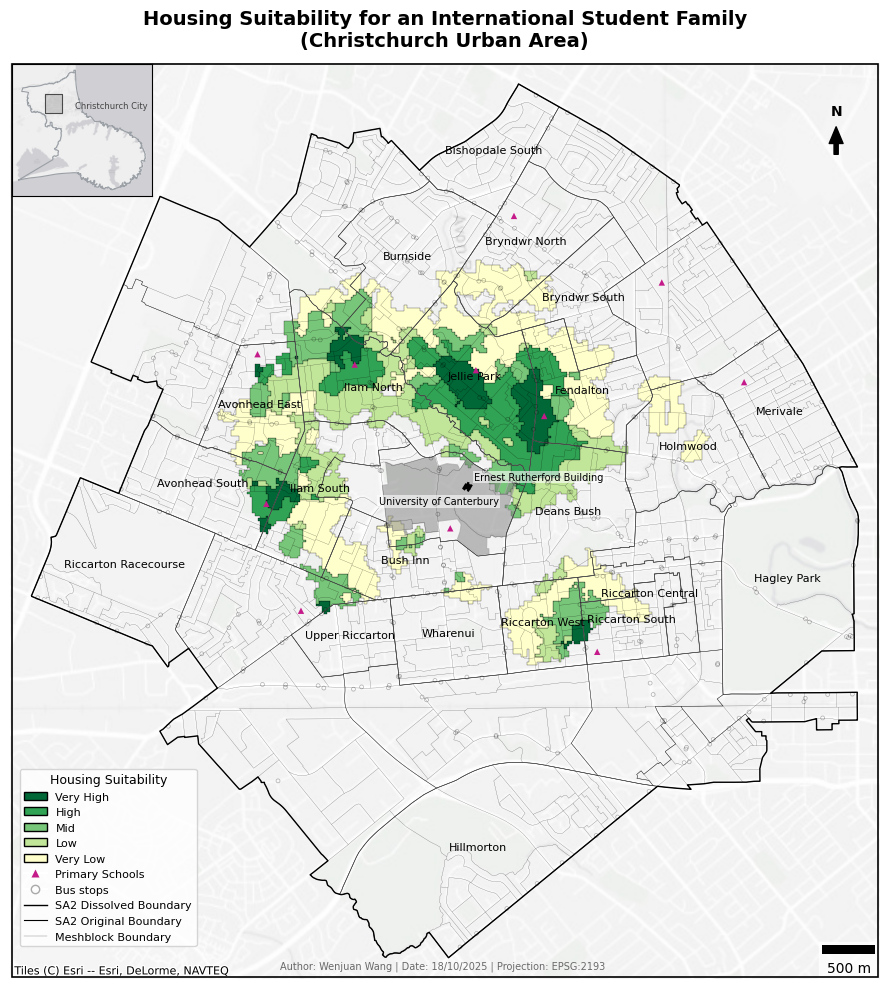

In [ ]:
# 1. Load Data & Preprocessing
grid_totalrank = grid_smooth.copy()
# Standardize categories and colors
cats5 = ["Very High","High","Mid","Low","Very Low"]
grid_totalrank["Total_quantile"] = pd.Categorical(
    grid_totalrank["Total_quantile"].astype(str).str.strip(),
    categories = cats5, ordered = True
)
palette5 = { "Very High": "#006837","High": "#31a354", "Mid": "#78c679", "Low": "#c2e699", "Very Low": "#ffffcc"}

# 2. Main map plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot suitability grid by categories 
for cat in cats5:
    sub = grid_totalrank[grid_totalrank["Total_quantile"] == cat]
    if len(sub):
        sub.plot(ax=ax, color=palette5[cat], edgecolor="black",
                 linewidth=0.2, alpha=1, zorder=1)

# 3. Legend, North Arrow and Scalebar
legend_elements = (    
    [Patch(facecolor = palette5[c], edgecolor='k', label=c) for c in cats5] +
    [Line2D([0], [0], marker='^', color='w', markerfacecolor='#c51b8a',
            markeredgecolor='none', markersize=6, label='Primary Schools')] +
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='none',markeredgecolor = "darkgray",
            markersize=6, label='Bus stops')] +
    [
    Line2D([0], [0], color='black', linewidth=1, label='SA2 Dissolved Boundary'),
    Line2D([0], [0], color='black', linewidth=0.8, label='SA2 Original Boundary'),
    Line2D([0], [0], color='gray',  linewidth=0.3, label='Meshblock Boundary')
    ]
)
ax.legend(handles=legend_elements, loc='lower left', frameon=True, bbox_to_anchor=(0.005, 0.03), 
          fontsize=8, title="Housing Suitability", title_fontsize=9)

def add_north(ax, loc=(0.95, 0.9), size=0.03):
    x, y = loc
    ax.annotate("", xy=(x, y+size), xytext=(x, y), xycoords=ax.transAxes,
                arrowprops=dict(facecolor="black", width=3, headwidth=10))
    ax.text(x, y+size+0.01, "N", transform=ax.transAxes,
            ha="center", va="bottom", fontsize=10, weight="bold")
add_north(ax)

scalebar = ScaleBar(
    dx=1,                  
    units="m",             
    dimension="si-length", 
    fixed_value=500,       
    fixed_units="m",       
    location="lower right", 
    box_alpha=0.7          
)
ax.add_artist(scalebar)

# 4. Add UC campus, primary schools & bus stops
uc_gdf = uc_gdf.to_crs(UNIFORM_CRS)
uc_gdf.boundary.plot(ax=ax, edgecolor="darkgray", linewidth=0.8, linestyle="-",alpha = 0.7)
uc_gdf.plot(ax=ax, color="gray", alpha=0.5)

centroid = uc_gdf.geometry.centroid.iloc[0]
ax.annotate(
    "University of Canterbury",
    xy=(centroid.x, centroid.y),
    xytext=(-50, -3),
    textcoords="offset points",
    fontsize=7, 
    color="black",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),    
)

bus_stations_in_sa2 = bus_stations_points[
    bus_stations_points.intersects(SA2_outline.geometry.iloc[0])
]
bus_stations_in_sa2.plot(ax=ax, markersize=8, color="none", edgecolor="black", linewidth=0.5, marker="o",zorder = 5, alpha=0.3)
schools_in_sa2  = primarySchool_points[primarySchool_points.intersects(SA2_outline.geometry.iloc[0])]
schools_in_sa2.plot(ax=ax, markersize=21, color="#c51b8a", edgecolor="none", linewidth=0.5, marker="^",zorder = 5)

# 5. SA2 & meshblock boundaries
SA2_outline = SA2_selected.dissolve()
SA2_selected.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=0.3, 
    linestyle="---", 
    zorder=3,
    alpha=0.5
)
SA2_outline.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=1, 
    linestyle="-", 
    zorder=4
)
meshblock = gpd.read_file("data/meshblock-2025-clipped.shp")
meshblock = meshblock.to_crs(uc_gdf.crs)
meshblock_in = gpd.overlay(meshblock, SA2_outline, how="intersection")
meshblock_in.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2, alpha=0.3,zorder = 2)

# 6. Annotation of ernest building and suburb labels
ernest_polygon.plot(ax=ax, color="black", linewidth=1.0)
ernest_centroid = ernest_polygon.geometry.centroid.iloc[0]
ax.annotate(
    "Ernest Rutherford Building",            
    xy=(ernest_centroid.x, ernest_centroid.y),  
    xytext=(5, 5),                           
    textcoords="offset points",
    fontsize=7,
    color="black",
    # weight="bold",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
)

suburbs = SA2_selected.copy()
target_suburbs = suburbs[suburbs["SA22025__1"].isin(["Burnside", "Fendalton", "Riccarton Central", "Bryndwr North", "Ilam North",
                                                     "Ilam South", "Avonhead East","Upper Riccarton","Avonhead South",
                                                     "Holmwood", "Bishopdale South","Bryndwr South", "Bush Inn","Merivale",
                                                     "Hagley Park","Hillmorton","Wharenui","Riccarton Racecourse","Riccarton West",
                                                     "Riccarton South","Jellie Park","Deans Bush"
                                                     ])]
target_suburbs.boundary.plot(ax=ax, color="grey", linewidth=0.5)
for idx, row in target_suburbs.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["SA22025__1"],
            fontsize=8, color="black", ha="center")

# 7. Inset map (locator)
boundary = ox.geocode_to_gdf("Christchurch City, Canterbury, New Zealand")
boundary = boundary.to_crs(UNIFORM_CRS)
axins = fig.add_axes([0.067, 0.794, 0.14, 0.14])
axins.set_facecolor("#F4F5F7")
axins.set_frame_on(True)

g_main = SA2_outline.to_crs(UNIFORM_CRS)
minx, miny, maxx, maxy = g_main.total_bounds
pad_m = 400
study_box = box(minx-pad_m, miny-pad_m, maxx+pad_m, maxy+pad_m)
study_gdf = gpd.GeoDataFrame(geometry=[study_box], crs=2193)
study_gdf.plot(ax=axins, color="#4A4A4A", alpha=0.2, edgecolor="none", zorder=3)
study_gdf.boundary.plot(ax=axins, color="#4A4A4A", linewidth=0.8, zorder=4)
boundary.boundary.plot(ax=axins, color="#9AA0A6", linewidth=0.8, zorder=2)
ctx.add_basemap(
    axins,
    source="https://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}",  
    crs=UNIFORM_CRS,
    zoom=11
)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axins.text(0.45, 0.65, "Christchurch City", transform=axins.transAxes,
           fontsize=6, color="#444", ha="left", va="bottom")

# 8. Final formatting 
pad_axes = 0.002
frame = Rectangle((pad_axes, pad_axes), 1-2*pad_axes, 1-2*pad_axes,
                  transform=ax.transAxes, fill=False,
                  edgecolor="black", linewidth=1.2, zorder=1000)
ax.add_patch(frame)
# Title and Metadata
ax.set_title(
    "Housing Suitability for an International Student Family\n(Christchurch Urban Area)",
    fontsize=14, weight="bold", loc="center", pad=12
)
ax.text(0.31, 0.02,
    "Author: Wenjuan Wang | Date: 18/10/2025 | Projection: EPSG:2193",
    transform=ax.transAxes, va="top", ha="left", fontsize=7, color="dimgray")
minx, miny, maxx, maxy = SA2_selected.total_bounds
pad = 200  
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad) 
# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldGrayCanvas,
    crs=UNIFORM_CRS,
    alpha=0.6
)
ax.set_aspect("equal"); ax.set_axis_off()
ax.grid(True, which='both', color='lightgray', linewidth=0.5)
plt.tight_layout()
plt.savefig("data/output/map_total_quantile_full1.png", dpi=400, bbox_inches="tight")
plt.show()

# 7. SA2-Level Housing Suitability Area Statistics
In this section, the grid-based housing suitability results are aggregated to the SA2 (Statistical Area 2) level in order to provide a neighborhood-scale perspective. By overlaying the suitability grids with SA2 boundaries and computing the total area for each suitability class, we can identify which suburbs contain larger proportions of highly suitable housing. 

In [ ]:
# Ensure CRS consistency (EPSG:2193)
grid = grid_totalrank.to_crs(UNIFORM_CRS)

# Overlay operation: calculate suitability polygons within each SA2
overlay = gpd.overlay(grid, SA2_selected, how="intersection")

# Calculate polygon area (unit: m², project to metric CRS)
overlay["area_m2"] = overlay.geometry.to_crs(UNIFORM_CRS).area  

# Group by SA2 name + Total_quantile and sum area
summary = overlay.groupby(["SA22025__1", "Total_quantile"], observed=True)["area_m2"].sum().reset_index()

# Pivot table: rows = SA2, columns = suitability level, values = area
pivot = summary.pivot_table(index="SA22025__1", 
                            columns="Total_quantile", 
                            values="area_m2", 
                            fill_value=0)

# Add total area and high-suitability area, round each suitability class area for readability
pivot["Total_area"] = round(pivot.sum(axis=1),0)
pivot["Total_high_area"] = round((pivot["High"] + pivot["Very High"]),0)
pivot["Very Low"] = round(pivot["Very Low"],0)
pivot["Low"] = round(pivot["Low"],0)
pivot["Mid"] = round(pivot["Mid"],0)
pivot["High"] = round(pivot["High"],0)
pivot["Very High"] = round(pivot["Very High"],0)

# Sort by high-suitability area (High + Very High)
pivot = pivot.sort_values(by="Total_high_area", ascending=False)

# Show top 10 SA2 ranked by high-suitability area
pivot.head(10)


C:\Users\wangw\AppData\Local\Temp\ipykernel_58072\4203812441.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = summary.pivot_table(index="SA22025__1",


Total_quantile,Very High,High,Mid,Low,Very Low,Total_area,Total_high_area
SA22025__1,,,,,,,
Jellie Park,264354.0,466793.0,134987.0,105784.0,309433.0,1281351.0,731147.0
Ilam North,69650.0,190203.0,188018.0,506489.0,98668.0,1053028.0,259853.0
Fendalton,78103.0,140631.0,43125.0,54279.0,358659.0,674797.0,218734.0
Deans Bush,10668.0,119485.0,5754.0,250023.0,43830.0,429760.0,130153.0
Ilam South,37022.0,57565.0,90158.0,139381.0,230386.0,554511.0,94587.0
Avonhead South,31728.0,43681.0,63113.0,8750.0,5828.0,153101.0,75409.0
Avonhead East,7922.0,40000.0,151930.0,98978.0,245371.0,544200.0,47922.0
Riccarton West,23063.0,0.0,109715.0,81036.0,215490.0,429303.0,23063.0
Riccarton South,11937.0,0.0,44312.0,0.0,63871.0,120120.0,11937.0
